In [10]:
## Goals of this experiment:
## - SGHMCHD is more robust with respect to different initial (smaller) stepsizes than SGHMC
## - SGHMCHD maintains reasonable uncertainty bounds of SGHMC 
%matplotlib inline
import numpy as np
import sys
from os.path import dirname, join as path_join, isdir
from glob import glob
import json
import pandas as pd

from collections import defaultdict

sys.path.insert(0, path_join("..", "..", ".."))

RESULT_DIR = path_join("..", "..", "..", "cluster_results", "sinc")


def load_results(directory):
    directories = [
        directory for directory in glob("{}/*".format(directory))
        if isdir(directory)
    ]
    
    def load_json(filename):
        with open(filename) as f:
            return json.load(f)
    
    configurations = tuple(
        load_json(path_join(directory, "config.json"))
        for directory in directories
        if "_sources" not in directory
    )
    
    results = tuple(
        load_json(path_join(directory, "run.json"))
        for directory in directories
        if "_sources" not in directory
    )
    from collections import defaultdict
    runs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    
    assert len(configurations) == len(results)
    print(len(configurations))
    for configuration, result in zip(configurations, results):
        if result["status"] == "COMPLETED":
            runs[configuration["data_seed"]][configuration["stepsize"]][configuration["sampler"]] = result
    return runs

runs = load_results(RESULT_DIR)

COLORS = {"SGHMC": ("red", "indianred"), 
          "SGHMCHD": ("green", "forestgreem")}

def plot_results(results):
    for stepsize in sorted(results):
        sampler_results = results[stepsize]
        for sampler, sampler_result in sampler_results.items():
            color_prediction, color_uncertainty = COLORS[sampler]
            x_train = np.asarray(sampler_result["result"]["x_train"])
            y_train = np.asarray(sampler_result["result"]["y_train"])
            x_test = np.asarray(sampler_result["result"]["x_test"])
            y_test = np.asarray(sampler_result["result"]["y_test"])
            prediction_mean = np.asarray(sampler_result["result"]["prediction_mean"])
            prediction_std = np.asarray(sampler_result["result"]["prediction_std"])
            
            plt.plot(x_test[:, 0], y_test, "--", label="sinc(x)", color="blue")
            plt.plot(x_train[:, 0], y_train, "bx")
            
            plt.plot(
                x_test[:, 0], prediction_mean,
                label=sampler,
                color=color_prediction
            )
            
            plt.fill_between(
                x_test[:, 0],
                prediction_mean + prediction_std,
                prediction_mean - prediction_std,
                alpha=0.2, color=color_uncertainty
            )
            plt.title("A fit of the sinc function using {} with stepsize {}".format(
                sampler, stepsize
            ))
            plt.legend()
            plt.show()
            
            
            

50


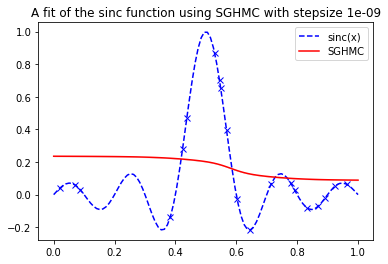

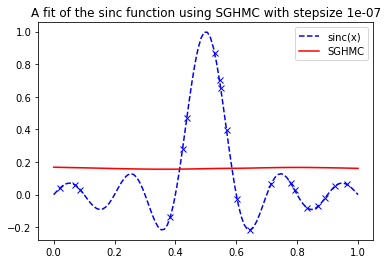

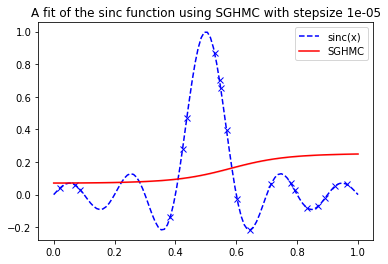

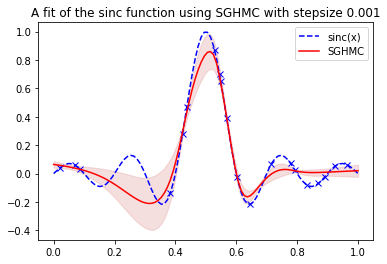

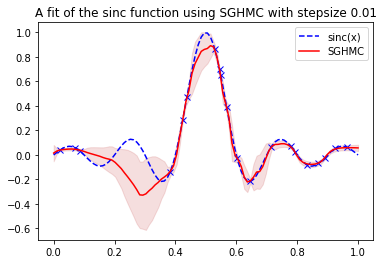

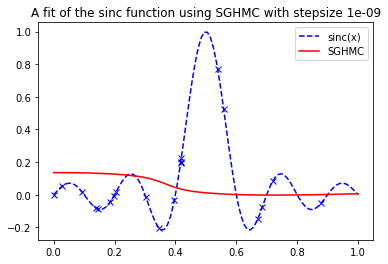

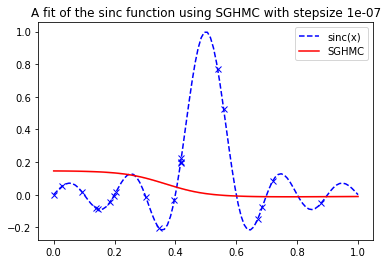

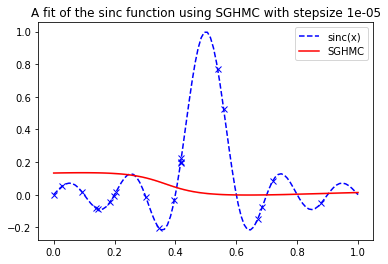

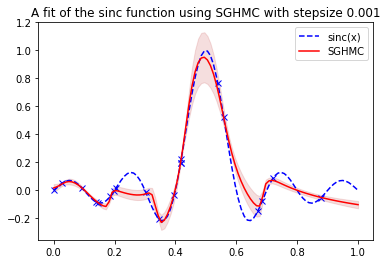

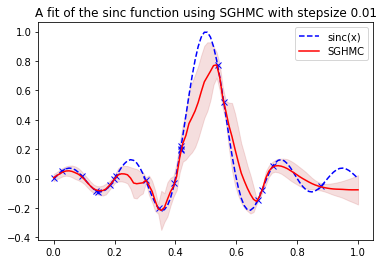

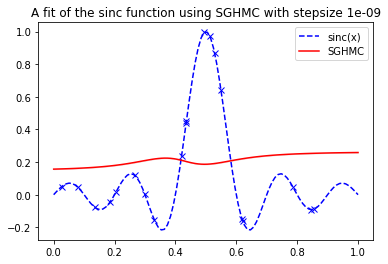

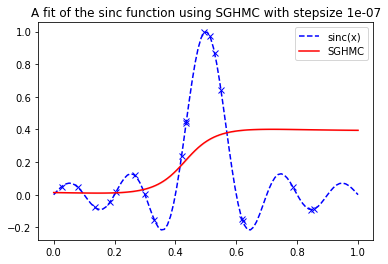

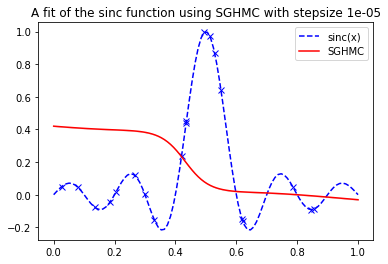

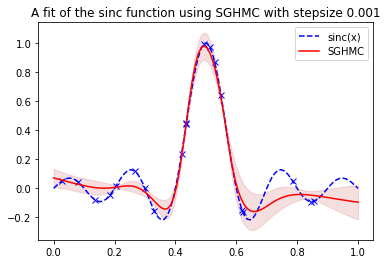

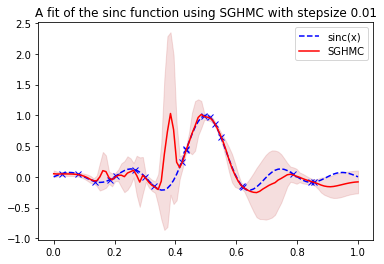

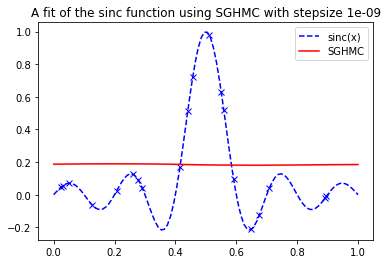

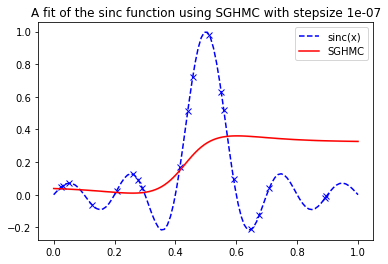

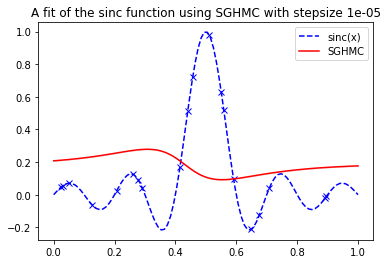

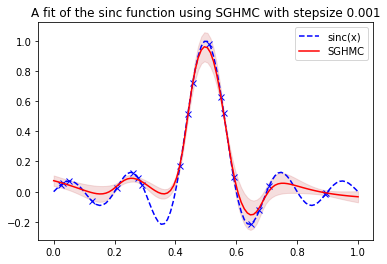

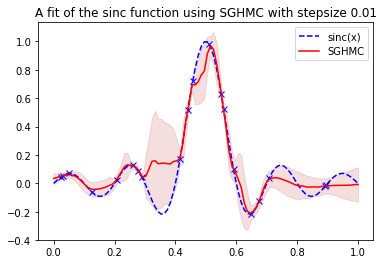

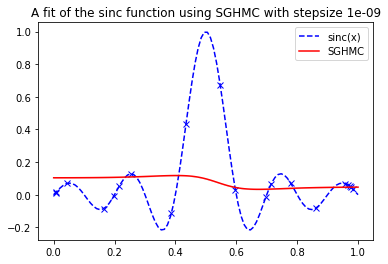

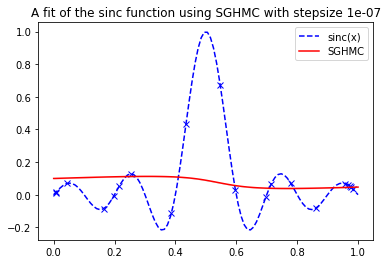

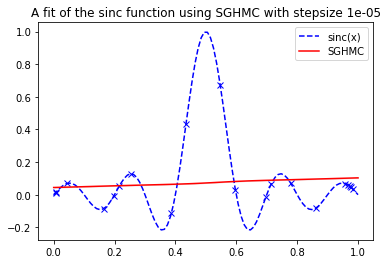

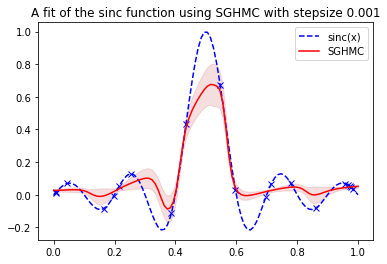

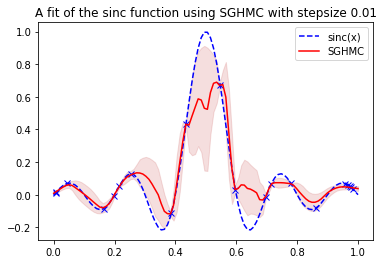

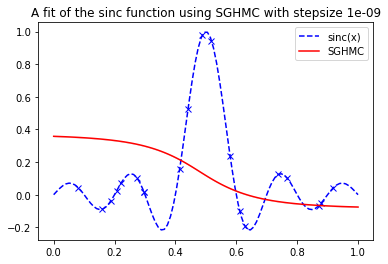

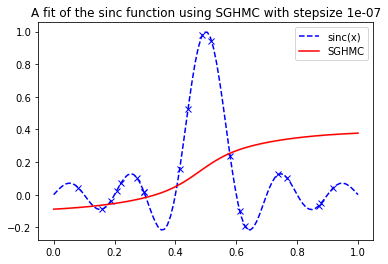

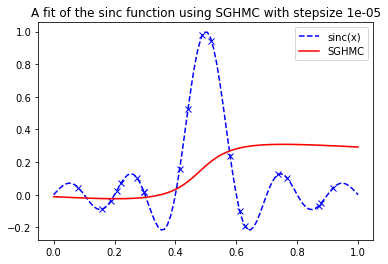

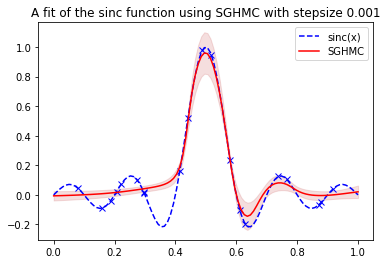

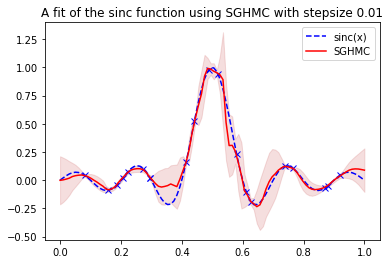

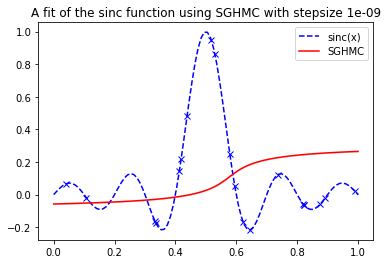

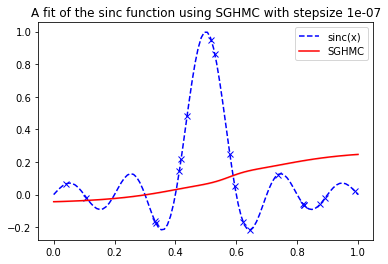

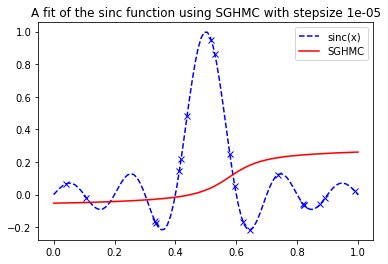

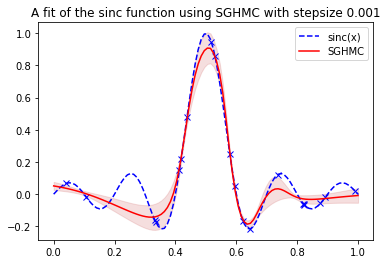

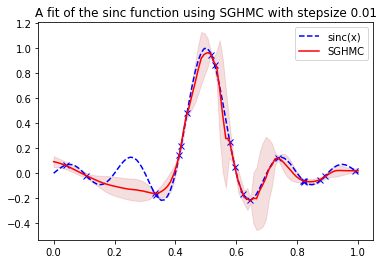

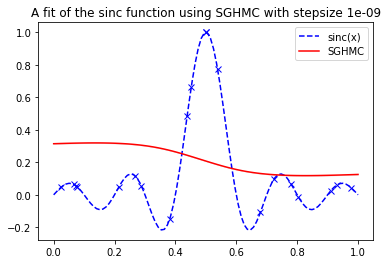

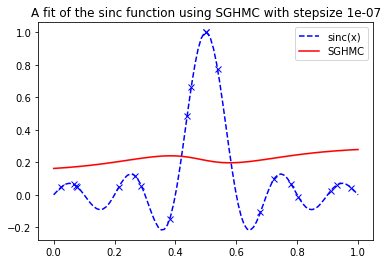

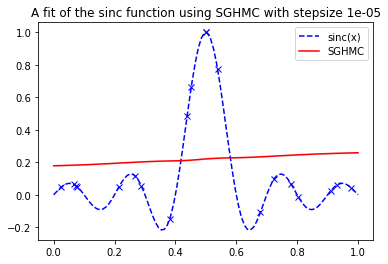

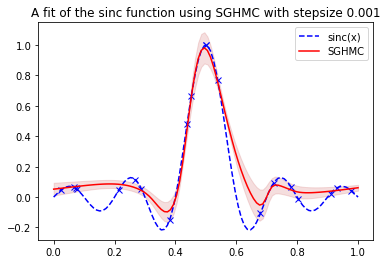

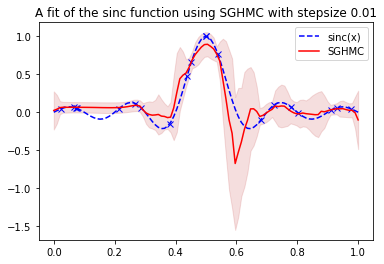

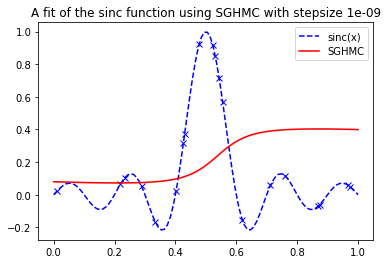

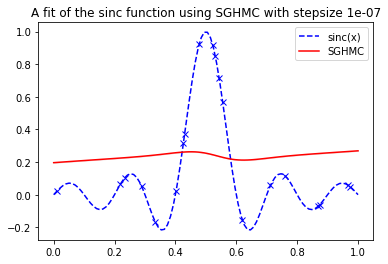

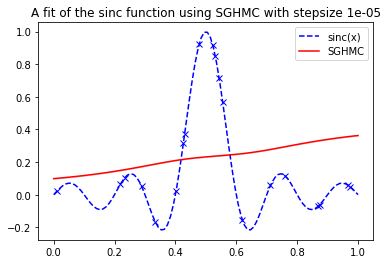

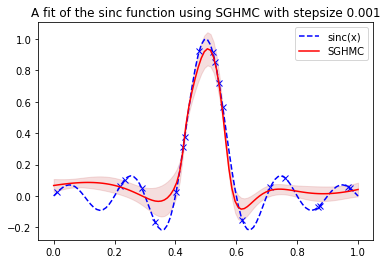

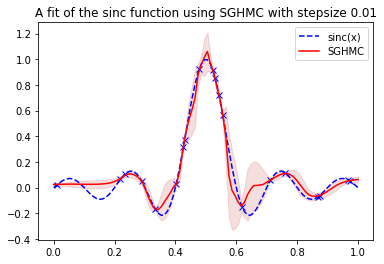

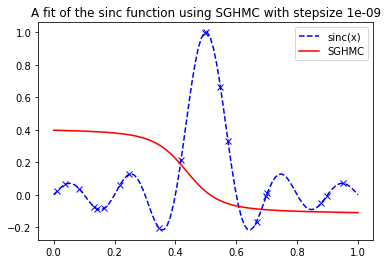

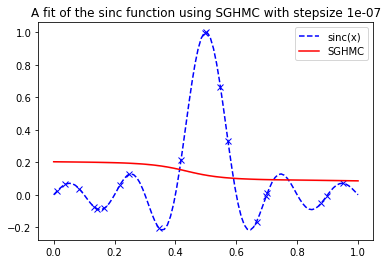

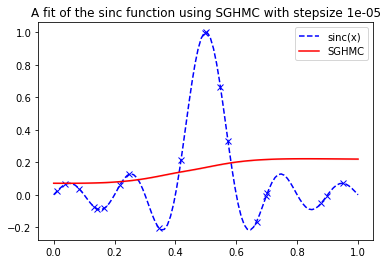

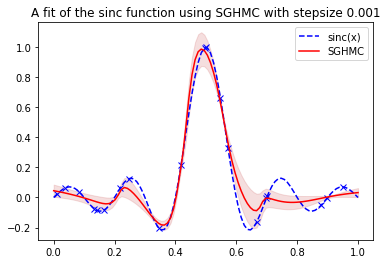

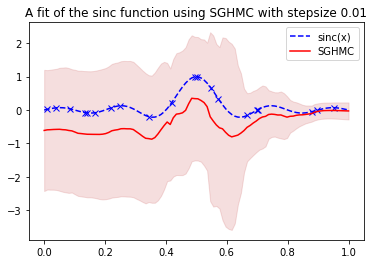

In [11]:
import matplotlib.pyplot as plt
for data_seed, seed_results in runs.items():
    plot_results(seed_results)
    